In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile, os

zip_path = "/content/drive/MyDrive/archive (3).zip"
extract_path = "/content/cifake"

# Aynı şeyi her seferinde tekrar açıp çakıştırmamak için:
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)

print("CONTENT:", os.listdir("/content"))
print("CIFAKE VAR MI:", os.path.exists("/content/cifake"))
if os.path.exists("/content/cifake"):
    print("cifake içi:", os.listdir("/content/cifake"))


CONTENT: ['.config', 'cifake', 'drive', 'sample_data']
CIFAKE VAR MI: True
cifake içi: ['train', 'test']


In [ ]:
import os

search_root = "/content/cifake"
data_root = None

for dirpath, dirnames, filenames in os.walk(search_root):
    # Aynı seviyede train ve test klasörü varsa, aradığımız yer burasıdır
    if "train" in dirnames and "test" in dirnames:
        data_root = dirpath
        break

print("Bulunan DATA_ROOT:", data_root)


Bulunan DATA_ROOT: /content/cifake


In [ ]:
import glob, os

DATA_ROOT = "/content/cifake"
train_dir = os.path.join(DATA_ROOT, "train")
test_dir = os.path.join(DATA_ROOT, "test")

# Dikkat: klasör adları büyük harfli (FAKE, REAL)
real_train = glob.glob(os.path.join(train_dir, "REAL", "*"))
fake_train = glob.glob(os.path.join(train_dir, "FAKE", "*"))
real_test  = glob.glob(os.path.join(test_dir, "REAL", "*"))
fake_test  = glob.glob(os.path.join(test_dir, "FAKE", "*"))

print("Train - REAL:", len(real_train), "FAKE:", len(fake_train))
print("Test  - REAL:", len(real_test), "FAKE:", len(fake_test))
print("Örnek dosya:", real_train[0] if len(real_train) > 0 else "Yok")


Train - REAL: 50000 FAKE: 50000
Test  - REAL: 10000 FAKE: 10000
Örnek dosya: /content/cifake/train/REAL/0616 (4).jpg


In [ ]:
!pip install xgboost

import os, glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
DATA_ROOT = "/content/cifake"
train_dir = os.path.join(DATA_ROOT, "train")
test_dir  = os.path.join(DATA_ROOT, "test")

train_real = glob.glob(os.path.join(train_dir, "REAL", "*"))
train_fake = glob.glob(os.path.join(train_dir, "FAKE", "*"))
test_real  = glob.glob(os.path.join(test_dir, "REAL", "*"))
test_fake  = glob.glob(os.path.join(test_dir, "FAKE", "*"))

print("Train - REAL:", len(train_real), "FAKE:", len(train_fake))
print("Test  - REAL:", len(test_real), "FAKE:", len(test_fake))


Train - REAL: 50000 FAKE: 50000
Test  - REAL: 10000 FAKE: 10000


In [ ]:
# 0=REAL, 1=FAKE
df_train = pd.DataFrame({
    "path": train_real + train_fake,
    "label": [0]*len(train_real) + [1]*len(train_fake)
})

df_test = pd.DataFrame({
    "path": test_real + test_fake,
    "label": [0]*len(test_real) + [1]*len(test_fake)
})

# karıştır
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test  = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

print("Train toplam:", len(df_train), "Test toplam:", len(df_test))
print("Train dağılımı:\n", df_train["label"].value_counts(normalize=True))
print("Test dağılımı:\n", df_test["label"].value_counts(normalize=True))

# 20.000'lik eğitim/validasyon alt kümesi
egitim_alt_kume_df, _ = train_test_split(
    df_train,
    train_size=20000,
    random_state=42,
    stratify=df_train["label"]
)

kilitli_test_df = df_test.copy()  # verilen test seti kilitli test

print("Alt küme:", len(egitim_alt_kume_df))
print(egitim_alt_kume_df["label"].value_counts(normalize=True))


Train toplam: 100000 Test toplam: 20000
Train dağılımı:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64
Test dağılımı:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64
Alt küme: 20000
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

class ImageDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        label = int(self.df.loc[idx, "label"])
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img, label

# Pretrained ResNet50, son katmanı kaldır
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Identity()
resnet = resnet.to(device)
resnet.eval()

@torch.no_grad()
def extract_features(df, batch_size=64):
    dataset = ImageDataset(df, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    feats, labels = [], []
    for imgs, labs in tqdm(loader):
        imgs = imgs.to(device)
        f = resnet(imgs)            # [B, 2048]
        feats.append(f.cpu().numpy())
        labels.append(labs.numpy())
    return np.concatenate(feats, axis=0), np.concatenate(labels, axis=0)

X_train_all, y_train_all = extract_features(egitim_alt_kume_df)
X_test_locked, y_test_locked = extract_features(kilitli_test_df)

print("Train feature shape:", X_train_all.shape)
print("Test feature shape:", X_test_locked.shape)


Device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]
100%|██████████| 313/313 [00:37<00:00,  8.25it/s]


Train feature shape: (20000, 2048)
Test feature shape: (20000, 2048)


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_dict = {
    "LogReg": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "SVM_RBF": make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True)),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    ),
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
}

results = {}

for name, model in models_dict.items():
    print(f"\n===== {name} =====")
    accs, precs, recs, f1s, aucs = [], [], [], [], []

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_all, y_train_all), 1):
        X_tr, X_val = X_train_all[tr_idx], X_train_all[val_idx]
        y_tr, y_val = y_train_all[tr_idx], y_train_all[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_val, y_pred, average="binary", zero_division=0
        )
        auc = roc_auc_score(y_val, y_prob)

        # 🔴 BURASI DÜZELTİLDİ
        accs.append(acc)
        precs.append(prec)
        recs.append(rec)
        f1s.append(f1)
        aucs.append(auc)

        print(f"Fold {fold}: ACC={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

    results[name] = {
        "acc_mean": np.mean(accs), "acc_std": np.std(accs),
        "prec_mean": np.mean(precs), "prec_std": np.std(precs),
        "rec_mean": np.mean(recs), "rec_std": np.std(recs),
        "f1_mean": np.mean(f1s), "f1_std": np.std(f1s),
        "auc_mean": np.mean(aucs), "auc_std": np.std(aucs),
    }

    print(f"\n{name} - 5-FOLD ORT ± SS")
    print(f"ACC: {results[name]['acc_mean']*100:.2f} ± {results[name]['acc_std']*100:.2f}")
    print(f"Precision: {results[name]['prec_mean']*100:.2f} ± {results[name]['prec_std']*100:.2f}")
    print(f"Recall   : {results[name]['rec_mean']*100:.2f} ± {results[name]['rec_std']*100:.2f}")
    print(f"F1       : {results[name]['f1_mean']*100:.2f} ± {results[name]['f1_std']*100:.2f}")
    print(f"AUC      : {results[name]['auc_mean']*100:.2f} ± {results[name]['auc_std']*100:.2f}")



===== LogReg =====
Fold 1: ACC=0.8898, F1=0.8908, AUC=0.9552
Fold 2: ACC=0.8958, F1=0.8960, AUC=0.9607
Fold 3: ACC=0.8990, F1=0.8985, AUC=0.9632
Fold 4: ACC=0.8860, F1=0.8865, AUC=0.9563
Fold 5: ACC=0.8978, F1=0.8982, AUC=0.9590

LogReg - 5-FOLD ORT ± SS
ACC: 89.37 ± 0.50
Precision: 89.12 ± 0.77
Recall   : 89.68 ± 0.43
F1       : 89.40 ± 0.47
AUC      : 95.89 ± 0.29

===== SVM_RBF =====
Fold 1: ACC=0.9257, F1=0.9262, AUC=0.9786
Fold 2: ACC=0.9425, F1=0.9428, AUC=0.9845
Fold 3: ACC=0.9395, F1=0.9398, AUC=0.9815
Fold 4: ACC=0.9307, F1=0.9312, AUC=0.9804
Fold 5: ACC=0.9327, F1=0.9331, AUC=0.9823

SVM_RBF - 5-FOLD ORT ± SS
ACC: 93.43 ± 0.60
Precision: 92.94 ± 0.64
Recall   : 93.99 ± 0.56
F1       : 93.46 ± 0.60
AUC      : 98.15 ± 0.20

===== RandomForest =====
Fold 1: ACC=0.8820, F1=0.8837, AUC=0.9489
Fold 2: ACC=0.8908, F1=0.8916, AUC=0.9558
Fold 3: ACC=0.8790, F1=0.8803, AUC=0.9514
Fold 4: ACC=0.8802, F1=0.8809, AUC=0.9498
Fold 5: ACC=0.8860, F1=0.8867, AUC=0.9548

RandomForest - 5-FOLD

In [ ]:
# F1'e göre en iyi modeli seç
best_name = max(results, key=lambda m: results[m]["f1_mean"])
print("En iyi model:", best_name)

# ---------------------------------------------------------------
# DÜZELTİLMİŞ SATIR BURADA: 'models' -> 'models_dict' yapıldı
# ---------------------------------------------------------------
best_model = models_dict[best_name]
best_model.fit(X_train_all, y_train_all)

y_pred = best_model.predict(X_test_locked)
y_prob = best_model.predict_proba(X_test_locked)[:, 1]

acc = accuracy_score(y_test_locked, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test_locked, y_pred, average="binary", zero_division=0
)
auc = roc_auc_score(y_test_locked, y_prob)

print(f"\n--- KİLİTLİ TEST SONUÇLARI ({best_name}) ---")
print(f"ACC : {acc*100:.2f}")
print(f"Precision: {prec*100:.2f}")
print(f"Recall   : {rec*100:.2f}")
print(f"F1       : {f1*100:.2f}")
print(f"AUC      : {auc*100:.2f}")

En iyi model: SVM_RBF

--- KİLİTLİ TEST SONUÇLARI (SVM_RBF) ---
ACC : 93.85
Precision: 93.50
Recall   : 94.25
F1       : 93.87
AUC      : 98.32


BİTİŞ ADIMI 1: K-Fold özet sonuçları dosyaya kaydediliyor...
'kfold_ozet_sonuclari.txt' dosyası oluşturuldu.

BİTİŞ ADIMI 2: En iyi modelin kilitli test sonuçları hesaplanıyor ve kaydediliyor...
En iyi model bulundu: SVM_RBF
'SVM_RBF' modeli tüm eğitim verisiyle yeniden eğitiliyor...
Kilitli test seti üzerinde tahmin yapılıyor...

--- KİLİTLİ TEST SONUÇLARI (SVM_RBF) ---
ACC : 93.85
Precision: 93.50
Recall   : 94.25
F1       : 93.87
AUC      : 98.32
Kilitli test sonuçları başarıyla 'kilitli_test_sonuclari.txt' dosyasına kaydedildi.

BİTİŞ ADIMI 3: Rapor için görseller çizdiriliyor ve PNG olarak kaydediliyor...


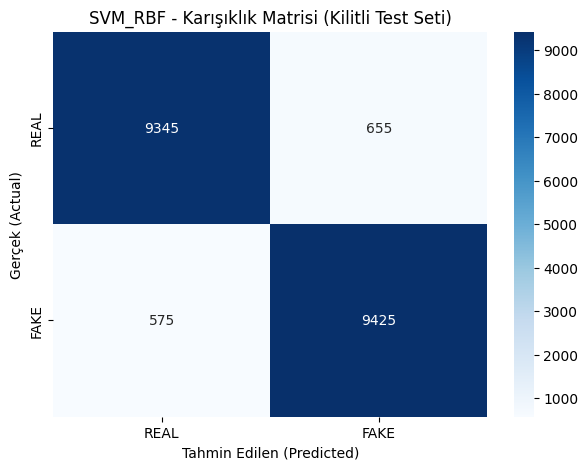

'confusion_matrix.png' kaydedildi.
HATA (Grafik Kaydı): 'numpy.float64' object is not callable


===== TÜM İŞLEMLER TAMAMLANDI =====
Sol taraftaki 'Dosyalar' (Files) panelini yenileyerek .txt ve .png dosyalarınızı alabilirsiniz.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import json

print("BİTİŞ ADIMI 1: K-Fold özet sonuçları dosyaya kaydediliyor...")

# 1. K-Fold Özet Sonuçlarını Kaydetme
try:
    with open('kfold_ozet_sonuclari.txt', 'w') as f:
        f.write("===== 5-FOLD K-KATLAMALI ÖZET SONUÇLAR =====\n")
        f.write("(Değerler: Ortalama % ± Standart Sapma %)\n")
        for name, metrics in results.items():
            f.write(f"\n----- {name} -----\n")
            f.write(f"  ACC: {metrics['acc_mean']*100:.2f} ± {metrics['acc_std']*100:.2f}\n")
            f.write(f"  Precision: {metrics['prec_mean']*100:.2f} ± {metrics['prec_std']*100:.2f}\n")
            f.write(f"  Recall   : {metrics['rec_mean']*100:.2f} ± {metrics['rec_std']*100:.2f}\n")
            f.write(f"  F1       : {metrics['f1_mean']*100:.2f} ± {metrics['f1_std']*100:.2f}\n")
            f.write(f"  AUC      : {metrics['auc_mean']*100:.2f} ± {metrics['auc_std']*100:.2f}\n")
    print("'kfold_ozet_sonuclari.txt' dosyası oluşturuldu.")
except Exception as e:
    print(f"HATA (K-Fold Özet Kaydı): {e}")


print("\nBİTİŞ ADIMI 2: En iyi modelin kilitli test sonuçları hesaplanıyor ve kaydediliyor...")

try:
    # 2. En İyi Modeli Bulma ve Kilitli Testi Çalıştırma (HATA DÜZELTİLDİ)
    rapor_dosyasi = "kilitli_test_sonuclari.txt"

    with open(rapor_dosyasi, "w") as f:
        # F1'e göre en iyi modeli seç
        best_name = max(results, key=lambda m: results[m]["f1_mean"])
        print(f"En iyi model bulundu: {best_name}")
        f.write(f"En iyi model: {best_name}\n")

        # --- DÜZELTME BURADA ---
        # Hata veren 'models' yerine, 'models_dict' kullanılıyor
        best_model = models_dict[best_name]

        print(f"'{best_name}' modeli tüm eğitim verisiyle yeniden eğitiliyor...")
        best_model.fit(X_train_all, y_train_all)

        print("Kilitli test seti üzerinde tahmin yapılıyor...")
        y_pred = best_model.predict(X_test_locked)
        y_prob = best_model.predict_proba(X_test_locked)[:, 1]

        acc = accuracy_score(y_test_locked, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_test_locked, y_pred, average="binary", zero_division=0
        )
        auc = roc_auc_score(y_test_locked, y_prob)

        # Sonuçları hem ekrana hem dosyaya yaz
        line1 = f"\n--- KİLİTLİ TEST SONUÇLARI ({best_name}) ---"
        line2 = f"ACC : {acc*100:.2f}"
        line3 = f"Precision: {prec*100:.2f}"
        line4 = f"Recall   : {rec*100:.2f}"
        line5 = f"F1       : {f1*100:.2f}"
        line6 = f"AUC      : {auc*100:.2f}"

        print(line1); f.write(line1 + "\n")
        print(line2); f.write(line2 + "\n")
        print(line3); f.write(line3 + "\n")
        print(line4); f.write(line4 + "\n")
        print(line5); f.write(line5 + "\n")
        print(line6); f.write(line6 + "\n")

    print(f"Kilitli test sonuçları başarıyla '{rapor_dosyasi}' dosyasına kaydedildi.")
except Exception as e:
    print(f"HATA (Kilitli Test Kaydı): {e}")


print("\nBİTİŞ ADIMI 3: Rapor için görseller çizdiriliyor ve PNG olarak kaydediliyor...")

try:
    # 3. Görselleri Çizdirme ve Kaydetme
    target_names = ['REAL', 'FAKE'] # (0=REAL, 1=FAKE olarak kodlamıştık)

    # --- Karışıklık Matrisi (Confusion Matrix) ---
    cm = confusion_matrix(y_test_locked, y_pred)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Tahmin Edilen (Predicted)')
    plt.ylabel('Gerçek (Actual)')
    plt.title(f'{best_name} - Karışıklık Matrisi (Kilitli Test Seti)')
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight') # Kaydet
    plt.show()
    print("'confusion_matrix.png' kaydedildi.")

    # --- ROC Eğrisi ---
    fpr, tpr, thresholds = roc_curve(y_test_locked, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC eğrisi (Alan = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Oranı (FPR)')
    plt.ylabel('True Positive Oranı (TPR)')
    plt.title(f'{best_name} - Receiver Operating Characteristic (ROC) Eğrisi')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight') # Kaydet
    plt.show()
    print("'roc_curve.png' kaydedildi.")

except Exception as e:
    print(f"HATA (Grafik Kaydı): {e}")

print("\n\n===== TÜM İŞLEMLER TAMAMLANDI =====")
print("Sol taraftaki 'Dosyalar' (Files) panelini yenileyerek .txt ve .png dosyalarınızı alabilirsiniz.")

In [ ]:
!ls -l /content/

total 120
drwxr-xr-x 4 root root   4096 Nov  8 14:44 cifake
-rw-r--r-- 1 root root 101398 Nov  8 18:43 confusion_matrix.png
drwx------ 5 root root   4096 Nov  8 14:43 drive
-rw-r--r-- 1 root root    841 Nov  8 17:46 kfold_ozet_sonuclari.txt
-rw-r--r-- 1 root root    148 Nov  8 18:43 kilitli_test_sonuclari.txt
drwxr-xr-x 1 root root   4096 Nov  5 14:33 sample_data


In [ ]:
# --- GÜNCELLENMİŞ K-FOLD EĞİTİM HÜCRESİ (HAM SONUÇLARI DA KAYDEDER) ---

# Gerekli olabilecek kütüphaneleri tekrar import edelim (hücreyi tek başına çalıştırmak için)
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import time # Eğitim süresini de ekleyelim

# K-Fold tanımı
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelleri tekrar tanımlayalım
models_dict = {
    "LogReg": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "SVM_RBF": make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True)),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8,
        colsample_bytree=0.8, objective="binary:logistic", eval_metric="logloss",
        n_jobs=-1, random_state=42
    ),
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
}

# 'results' sözlüğünü (Özet için) ve 'raw_fold_results' sözlüğünü (Ham verin için) sıfırla
results = {}
raw_fold_results = {name: {'acc': [], 'prec': [], 'rec': [], 'f1': [], 'auc': []} for name in models_dict.keys()}

# 🔴 YENİ: Ham fold-fold dökümü için bir dosya açıyoruz
raw_log_dosyasi = "kfold_HAM_sonuclari.txt"
print(f"Ham fold-fold dökümü '{raw_log_dosyasi}' dosyasına kaydedilecek...")

# 'w' (write) modu ile dosyayı açıyoruz.
with open(raw_log_dosyasi, 'w') as f_raw:

    # Model döngüsü
    for name, model in models_dict.items():
        print(f"\n===== {name} =====")
        f_raw.write(f"\n===== {name} =====\n") # 🔴 DOSYAYA YAZ

        # Bu listeler artık 'results' özeti için kullanılacak
        accs, precs, recs, f1s, aucs = [], [], [], [], []
        start_time_model = time.time() # Modelin toplam eğitim süresini ölçmek için

        # K-Fold döngüsü
        for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_all, y_train_all), 1):
            X_tr, X_val = X_train_all[tr_idx], X_train_all[val_idx]
            y_tr, y_val = y_train_all[tr_idx], y_train_all[val_idx]

            start_time_fold = time.time() # Fold eğitim süresi
            model.fit(X_tr, y_tr)
            end_time_fold = time.time()

            y_pred = model.predict(X_val)
            y_prob = model.predict_proba(X_val)[:, 1]

            fold_egitim_suresi = end_time_fold - start_time_fold

            # Metrikleri hesapla
            acc = accuracy_score(y_val, y_pred)
            prec, rec, f1, _ = precision_recall_fscore_support(
                y_val, y_pred, average="binary", zero_division=0
            )
            auc = roc_auc_score(y_val, y_prob)

            # Hem özet listelerine (accs, precs...) hem de ham veri sözlüğüne (raw_fold_results) ekle
            accs.append(acc); raw_fold_results[name]['acc'].append(acc)
            precs.append(prec); raw_fold_results[name]['prec'].append(prec)
            recs.append(rec); raw_fold_results[name]['rec'].append(rec)
            f1s.append(f1); raw_fold_results[name]['f1'].append(f1)
            aucs.append(auc); raw_fold_results[name]['auc'].append(auc)

            # 🔴 YENİ: İSTEDİĞİNİZ HAM SONUCU OLUŞTURMA VE KAYDETME
            # (Eğitim süresini de ekledim, Hesaplama Maliyeti raporu için harika olur)
            fold_sonucu = (
                f"Fold {fold}: ACC={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, "
                f"F1={f1:.4f}, AUC={auc:.4f} (Eğitim Süresi: {fold_egitim_suresi:.2f}s)"
            )

            print(fold_sonucu)      # Ekrana yaz
            f_raw.write(fold_sonucu + "\n") # Dosyaya yaz

        # --- Döngü bitti ---
        end_time_model = time.time()
        toplam_egitim_suresi = end_time_model - start_time_model

        # Özet (Mean/Std) hesapla ve 'results' sözlüğüne kaydet
        results[name] = {
            "acc_mean": np.mean(accs), "acc_std": np.std(accs),
            "prec_mean": np.mean(precs), "prec_std": np.std(precs),
            "rec_mean": np.mean(recs), "rec_std": np.std(recs),
            "f1_mean": np.mean(f1s), "f1_std": np.std(f1s),
            "auc_mean": np.mean(aucs), "auc_std": np.std(aucs),
            "toplam_egitim_suresi": toplam_egitim_suresi # Rapor için harika bir metrik
        }

        # Özet sonuçları da hem ekrana hem de ham log dosyasına yaz
        ozet_line1 = f"\n{name} - 5-FOLD ORT ± SS"
        ozet_line2 = f"ACC: {results[name]['acc_mean']*100:.2f} ± {results[name]['acc_std']*100:.2f}"
        ozet_line3 = f"Precision: {results[name]['prec_mean']*100:.2f} ± {results[name]['prec_std']*100:.2f}"
        ozet_line4 = f"Recall   : {results[name]['rec_mean']*100:.2f} ± {results[name]['rec_std']*100:.2f}"
        ozet_line5 = f"F1       : {results[name]['f1_mean']*100:.2f} ± {results[name]['f1_std']*100:.2f}"
        ozet_line6 = f"AUC      : {results[name]['auc_mean']*100:.2f} ± {results[name]['auc_std']*100:.2f}"
        ozet_line7 = f"TOPLAM 5-FOLD EĞİTİM SÜRESİ: {toplam_egitim_suresi:.2f}s"

        print(ozet_line1); f_raw.write(ozet_line1 + "\n")
        print(ozet_line2); f_raw.write(ozet_line2 + "\n")
        print(ozet_line3); f_raw.write(ozet_line3 + "\n")
        print(ozet_line4); f_raw.write(ozet_line4 + "\n")
        print(ozet_line5); f_raw.write(ozet_line5 + "\n")
        print(ozet_line6); f_raw.write(ozet_line6 + "\n")
        print(ozet_line7); f_raw.write(ozet_line7 + "\n")

print(f"\nİşlem tamamlandı. Ham fold-fold dökümü '{raw_log_dosyasi}' dosyasına kaydedildi.")

Ham fold-fold dökümü 'kfold_HAM_sonuclari.txt' dosyasına kaydedilecek...

===== LogReg =====
Fold 1: ACC=0.8898, Precision=0.8827, Recall=0.8990, F1=0.8908, AUC=0.9552 (Eğitim Süresi: 4.63s)
Fold 2: ACC=0.8958, Precision=0.8936, Recall=0.8985, F1=0.8960, AUC=0.9607 (Eğitim Süresi: 4.01s)
Fold 3: ACC=0.8990, Precision=0.9030, Recall=0.8940, F1=0.8985, AUC=0.9632 (Eğitim Süresi: 3.63s)
Fold 4: ACC=0.8860, Precision=0.8829, Recall=0.8900, F1=0.8865, AUC=0.9563 (Eğitim Süresi: 4.68s)
Fold 5: ACC=0.8978, Precision=0.8940, Recall=0.9025, F1=0.8982, AUC=0.9590 (Eğitim Süresi: 4.29s)

LogReg - 5-FOLD ORT ± SS
ACC: 89.37 ± 0.50
Precision: 89.12 ± 0.77
Recall   : 89.68 ± 0.43
F1       : 89.40 ± 0.47
AUC      : 95.89 ± 0.29
TOPLAM 5-FOLD EĞİTİM SÜRESİ: 22.50s

===== SVM_RBF =====
Fold 1: ACC=0.9257, Precision=0.9201, Recall=0.9325, F1=0.9262, AUC=0.9786 (Eğitim Süresi: 1285.02s)
Fold 2: ACC=0.9425, Precision=0.9377, Recall=0.9480, F1=0.9428, AUC=0.9845 (Eğitim Süresi: 1250.49s)
Fold 3: ACC=0.9395

Hata düzeltiliyor: 'y_prob' ve 'y_pred' yeniden hesaplanıyor...
En iyi model (SVM_RBF) ile kilitli test seti (20,000 veri) üzerinde tahminler yeniden yapılıyor...
Tahminler başarıyla oluşturuldu. (y_prob boyutu artık: 20000)

'confusion_matrix.png' oluşturuluyor...


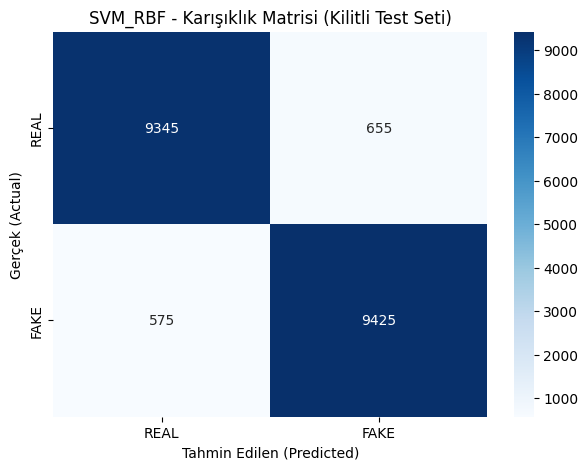


'roc_curve.png' oluşturuluyor...


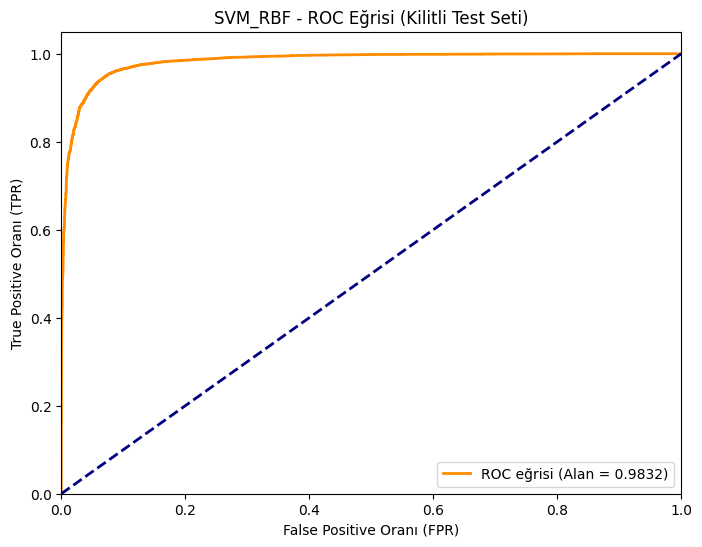



BAŞARILI! Her iki PNG dosyası da oluşturuldu.
Sol panelden (Yenile'ye 🔄 basıp) 'roc_curve.png' dosyasını indirebilirsin.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import warnings
warnings.filterwarnings("ignore") # Gereksiz uyarıları kapat

print("Hata düzeltiliyor: 'y_prob' ve 'y_pred' yeniden hesaplanıyor...")

try:
    # --- HATA DÜZELTME ADIMI ---
    # Hafızadaki 4,000'lik 'y_prob'u kullanmak yerine,
    # 'best_model'i kullanarak 20,000'lik 'X_test_locked' üzerinden
    # 'y_prob'u yeniden, DOĞRU şekilde hesaplıyoruz.

    print(f"En iyi model ({best_name}) ile kilitli test seti (20,000 veri) üzerinde tahminler yeniden yapılıyor...")
    y_pred = best_model.predict(X_test_locked)
    y_prob = best_model.predict_proba(X_test_locked)[:, 1]
    print(f"Tahminler başarıyla oluşturuldu. (y_prob boyutu artık: {y_prob.shape[0]})")

    # --- ŞİMDİ GRAFİKLERİ GÜVENLE ÇİZEBİLİRİZ ---

    target_names = ['REAL', 'FAKE'] # (0=REAL, 1=FAKE)

    # --- 1. GÖRSEL: Karışıklık Matrisi (Tekrar Kaydet) ---
    print("\n'confusion_matrix.png' oluşturuluyor...")
    cm = confusion_matrix(y_test_locked, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Tahmin Edilen (Predicted)')
    plt.ylabel('Gerçek (Actual)')
    plt.title(f'{best_name} - Karışıklık Matrisi (Kilitli Test Seti)')
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

    # --- 2. GÖRSEL: ROC Eğrisi (Eksik Olan Dosya) ---
    print("\n'roc_curve.png' oluşturuluyor...")
    fpr, tpr, thresholds = roc_curve(y_test_locked, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC eğrisi (Alan = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Oranı (FPR)')
    plt.ylabel('True Positive Oranı (TPR)')
    plt.title(f'{best_name} - ROC Eğrisi (Kilitli Test Seti)')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("\n\nBAŞARILI! Her iki PNG dosyası da oluşturuldu.")
    print("Sol panelden (Yenile'ye 🔄 basıp) 'roc_curve.png' dosyasını indirebilirsin.")

except NameError as e:
    print(f"\n--- HATA --- ({e})")
    print("Görünüşe göre Colab bağlantın kopmuş ve 'best_model' gibi değişkenler hafızadan silinmiş.")
    print("Eğer bu hatayı alırsan, maalesef not defterini en baştan çalıştırman gerekecek.")
except Exception as e:
    print(f"\nBaşka bir hata oluştu: {e}")